In [1]:
%set_env SHELL=/bin/bash
%set_env OMP_NUM_THREADS=8

env: SHELL=/bin/bash
env: OMP_NUM_THREADS=8


In [41]:
import mbuild
import foyer
import unyt as u
import mosdef_cassandra as mc
import matplotlib.pyplot as plt
%matplotlib inline

# Create a methane UA molecule (Effectively a LJ Particle)
methane = mbuild.Compound(name="_CH4")

# How many Molecules I am Initiallizing my System With
Nmolecules_1 = 256
Nmolecules_2 = 256

# Length of the Cubic Box (nm)
LBox_1 = 3.5
LBox_2 = 3.5

# Load the forcefield via foyer
ff = foyer.forcefields.load_TRAPPE_UA()

# Apply the forcefield parameters to methane with foyer
methane_ff = ff.apply(methane)

# Define an empty simulation box (in nm)
box_1 = mbuild.Box([LBox_1, LBox_1, LBox_1])
box_2 = mbuild.Box([LBox_2, LBox_2, LBox_2])

# Define the boxes, species in the system, molecules in the box
ensemble = 'gemc'
box_list = [box_1, box_2]
species_list = [methane_ff]
molecules_to_add = [[Nmolecules_1], [Nmolecules_2]]

# Create the System
system = mc.System(box_list, species_list, mols_to_add=molecules_to_add)

/home/woodrowwilson/Programs/miniconda3/lib/python3.9/site-packages/mbuild/conversion.py:1747: UserWarning: No element attribute associated with '<_CH4 pos=([0. 0. 0.]), 0 bonds, id: 140369925176720>'; and no matching elements found based upon the compound name. Setting atomic number to zero.
  warn(warn_msg)
/home/woodrowwilson/Programs/miniconda3/lib/python3.9/site-packages/parmed/openmm/topsystem.py:240: OpenMMWarning: Adding what seems to be Urey-Bradley terms before Angles. This is unexpected, but the parameters will all be present in one form or another.
  warnings.warn('Adding what seems to be Urey-Bradley terms before ' # pragma: no cover


In [42]:
# Create the MoveSet
moveset = mc.MoveSet(ensemble, species_list)
moveset.print()


Ensemble:  gemc

Probability of selecting each move type:

    Translate: 0.895
    Rotate:    0.0
    Regrow:    0.0
    Volume:    0.005
    Insert:    0.0
    Delete:    0.0
    Swap:      0.1
    Angle:     0.0
    Dihedral:  0.0

CBMC selections:

    Number of trial positions: 10
    Number of trial dihedral angles: 10
    CBMC cutoff(s): 
        Box 1: 6.0 Å
        Box 2: 6.0 Å


Per species quantities:

                             species1     
    Max translate (Ang):     2.00 Å          (Box 1)
                             2.00 Å          (Box 2)
    Max rotate (deg):        0.00 degree         (Box 1)
                             0.00 degree         (Box 2)
    Insertable:              True          
    Max dihedral:            0.00 degree          
    Prob swap:               1.00          
    Prob regrow:             0.00          


Max volume (Ang^3):
    Box 1: 500.0 Å**3



In [43]:
moveset.cbmc_n_insert = 12
moveset.print()


Ensemble:  gemc

Probability of selecting each move type:

    Translate: 0.895
    Rotate:    0.0
    Regrow:    0.0
    Volume:    0.005
    Insert:    0.0
    Delete:    0.0
    Swap:      0.1
    Angle:     0.0
    Dihedral:  0.0

CBMC selections:

    Number of trial positions: 12
    Number of trial dihedral angles: 10
    CBMC cutoff(s): 
        Box 1: 6.0 Å
        Box 2: 6.0 Å


Per species quantities:

                             species1     
    Max translate (Ang):     2.00 Å          (Box 1)
                             2.00 Å          (Box 2)
    Max rotate (deg):        0.00 degree         (Box 1)
                             0.00 degree         (Box 2)
    Insertable:              True          
    Max dihedral:            0.00 degree          
    Prob swap:               1.00          
    Prob regrow:             0.00          


Max volume (Ang^3):
    Box 1: 500.0 Å**3



In [44]:
# Run a Monte Carlo simulation!
custom_args = {
    "units": "sweeps",
    "steps_per_sweep": Nmolecules_1+Nmolecules_2,
    "vdw_cutoff":14.0 * u.Angstrom,
    "charge_style": "none",
    "charge_cutoff":14.0 * u.Angstrom,
    "prop_freq": 100,
    "coord_freq": 100,
    "run_name": "equil",
    "seeds":[12345, 67890]
}

mc.run(
    system=system,
    moveset=moveset,
    run_type="equilibration",
    run_length=2500,
    temperature=150.0 * u.K,
    **custom_args
)

mc.restart(
    restart_from="equil",
    run_name="prod",
    run_type="production",
    total_run_length=5000,
)

print("MC Simulation Finished")

Using the following executables for Cassandra:
Python: /home/woodrowwilson/Programs/miniconda3/bin/python
library_setup: /home/woodrowwilson/Programs/cassandra/1.2.6/Exe/library_setup.py
Cassandra: /home/woodrowwilson/Programs/cassandra/1.2.6/Exe/cassandra.exe
Generating fragment libraries...
Running Cassandra...


/home/woodrowwilson/Programs/miniconda3/lib/python3.9/site-packages/mbuild/formats/cassandramcf.py:219: UserWarning: No bonds found. Cassandra will interpet this as a rigid species
  warnings.warn(


Using the following executables for Cassandra:
Python: /home/woodrowwilson/Programs/miniconda3/bin/python
library_setup: /home/woodrowwilson/Programs/cassandra/1.2.6/Exe/library_setup.py
Cassandra: /home/woodrowwilson/Programs/cassandra/1.2.6/Exe/cassandra.exe
Running Cassandra...
MC Simulation Finished


In [51]:
!ls -lhtr

total 2.6M
-rw-rw-r-- 1 woodrowwilson woodrowwilson   200 Jul 12 23:06 species1.pdb
-rw-rw-r-- 1 woodrowwilson woodrowwilson  1.3K Jul 12 23:06 species1.mcf
drwxrwxr-x 4 woodrowwilson woodrowwilson  4.0K Jul 12 23:06 species1/
-rw-rw-r-- 1 woodrowwilson woodrowwilson  2.7K Jul 12 23:06 equil.inp
-rw-rw-r-- 1 woodrowwilson woodrowwilson   51K Jul 12 23:07 equil.out.chk
-rw-rw-r-- 1 woodrowwilson woodrowwilson   86K Jul 12 23:07 equil.out.box1.xyz
-rw-rw-r-- 1 woodrowwilson woodrowwilson  2.7K Jul 12 23:07 prod.inp
-rw-rw-r-- 1 woodrowwilson woodrowwilson  1.1K Jul 12 23:07 mosdef_cassandra_2022-07-12_23:06:14.345053.log
-rw-rw-r-- 1 woodrowwilson woodrowwilson   90K Jul 12 23:07 equil.out.log
-rw-rw-r-- 1 woodrowwilson woodrowwilson  1.1M Jul 12 23:07 equil.out.box2.xyz
-rw-rw-r-- 1 woodrowwilson woodrowwilson  4.4K Jul 12 23:07 equil.out.box2.prp
-rw-rw-r-- 1 woodrowwilson woodrowwilson  7.7K Jul 12 23:07 equil.out.box2.H
-rw-rw-r-- 1 woodrowwilson woodrowwilson  4.4K Jul 12 23:07 equi

In [46]:
import pandas as pd

def read_cassandra_prp(filename):
    with open(filename) as fh:
        #First line
        fh.readline()
        #Secondline
        column_names = fh.readline().split()
        del column_names[0]
    
    return pd.read_table(filename, skiprows=3, names=column_names, delim_whitespace=True)

df_box1_eq = read_cassandra_prp("equil.out.box1.prp")
df_box2_eq = read_cassandra_prp("equil.out.box2.prp")

df_box1_pd = read_cassandra_prp("prod.out.box1.prp")
df_box2_pd = read_cassandra_prp("prod.out.box2.prp")

<AxesSubplot:xlabel='MC_SWEEP'>

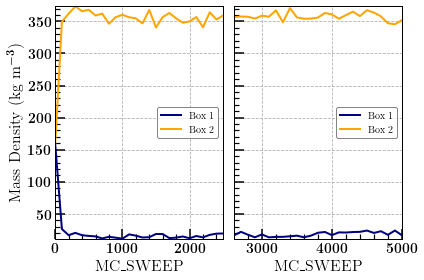

In [47]:
fig, ax = plt.subplots(nrows=1, ncols=2,sharey=True)

ax[0].set_ylabel("Mass Density (kg  m$^{-3}$)")

df_box1_eq.plot(x="MC_SWEEP", y="Mass_Density", ax=ax[0], label="Box 1")
df_box2_eq.plot(x="MC_SWEEP", y="Mass_Density", ax=ax[0], label="Box 2")
df_box1_pd.plot(x="MC_SWEEP", y="Mass_Density", ax=ax[1], label="Box 1")
df_box2_pd.plot(x="MC_SWEEP", y="Mass_Density", ax=ax[1], label="Box 2")

In [48]:
df_box1_pd.describe()

,MC_SWEEP,Energy_Total,Energy_Intra,Energy_Inter,Enthalpy,Pressure,Volume,Nmols,Mass_Density
count,25.000000,25.000000,25.0,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,3800.000000,-14.081970,0.0,-14.081970,20.588135,11.458313,50204.705760,34.880000,18.468977
std,735.980072,6.199820,0.0,6.199820,8.295784,2.664242,872.508932,7.037519,3.508589
min,2600.000000,-29.485557,0.0,-29.485557,1.257881,7.215874,48602.001000,25.000000,13.472858
25%,3200.000000,-17.752379,0.0,-17.752379,15.721234,9.235930,49501.034000,30.000000,16.083217
50%,3800.000000,-14.351391,0.0,-14.351391,19.089097,11.274370,50265.185000,33.000000,17.573934
75%,4400.000000,-9.072792,0.0,-9.072792,26.763430,13.535267,50794.219000,42.000000,21.746819
max,5000.000000,-3.885383,0.0,-3.885383,36.033345,16.028420,52034.995000,47.000000,24.099646


In [49]:
df_box2_pd.describe()

,MC_SWEEP,Energy_Total,Energy_Intra,Energy_Inter,Enthalpy,Pressure,Volume,Nmols,Mass_Density
count,25.000000,25.000000,25.0,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,3800.000000,-2854.264004,0.0,-2854.264004,-2850.556600,2.689243,35545.421560,477.120000,357.702516
std,735.980072,59.486141,0.0,59.486141,145.305197,66.719445,872.509072,7.037519,6.207000
min,2600.000000,-2981.677300,0.0,-2981.677300,-3094.732800,-105.621320,33715.132000,465.000000,345.517430
25%,3200.000000,-2874.639200,0.0,-2874.639200,-2920.425000,-32.844511,34955.908000,470.000000,354.229580
50%,3800.000000,-2861.944700,0.0,-2861.944700,-2890.786200,-5.246819,35484.942000,479.000000,357.231690
75%,4400.000000,-2825.407500,0.0,-2825.407500,-2781.636300,21.657069,36249.093000,482.000000,360.799730
max,5000.000000,-2692.162900,0.0,-2692.162900,-2446.312700,179.823890,37148.127000,487.000000,370.655050
